In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
# reflect the tables
inspector = inspect(engine)
tables = inspector.get_table_names()
tables


['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
for table in tables:
    columns = inspector.get_columns(f'{table}')
    print(f'The table {table} contain the following column')
    for c in columns:
        print(c['name'], c["type"])
    print('\n')

The table measurement contain the following column
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


The table station contain the following column
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT




In [8]:
# Check Measurement table df using SQL command
conn = engine.connect()
measurement_df = pd.read_sql("SELECT * FROM measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [9]:
# Check Station table df using SQL command
station_df = pd.read_sql("SELECT * FROM station", conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

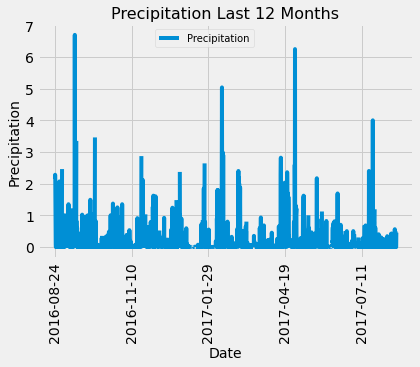

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get the latest date of the data
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date
# Calculate the date 1 year ago from the last data point in the database
last_12m = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_12m
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, (Measurement.prcp)]
last_12m_prcp = session.query(*sel).\
    filter(Measurement.date > last_12m).all()

last_12m_prcp                
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_12m_prcp, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values('Date', inplace = True)
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y = 'Precipitation')
plt.legend(bbox_to_anchor=(.3,1), fontsize="10")
plt.title("Precipitation Last 12 Months", size=16)
plt.ylabel("Precipitation", size=14)
plt.xlabel("Date", size=14)
plt.xticks(rotation = 90)
# plt.savefig('/Output/Precipitation_no_avg.png')
plt.show()

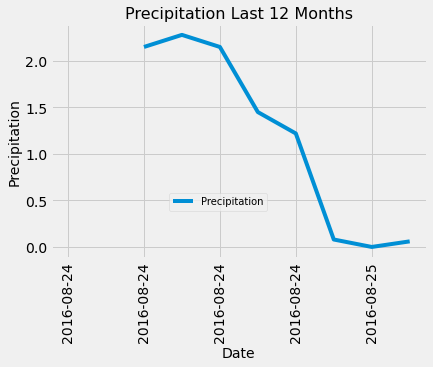

In [13]:
# The figure above cell matches the Gitlab solution. However, I dont agree with the result presented. If we go deeper, the total data will be more than 365 days, meaning in a day there will be more observations reported from various stations. The plot doesnt give us clue on at which location doest the measurement taken place for the same dates

# In this cell I just visualize 10 data to be plot. It can be seen that on the 2016-08-24 there are few data were plots.
precipitation_df[:10].plot(x='Date', y = 'Precipitation')
plt.legend(bbox_to_anchor=(.3,0.3), fontsize="10")
plt.title("Precipitation Last 12 Months", size=16)
plt.ylabel("Precipitation", size=14)
plt.xlabel("Date", size=14)
plt.xticks(rotation = 90)
plt.show()

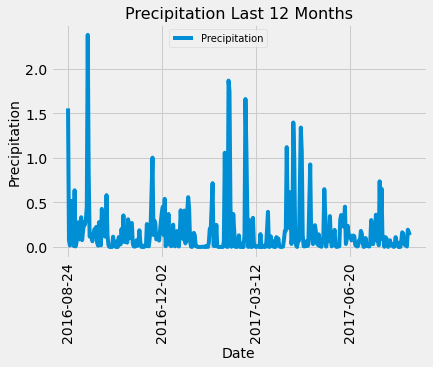

In [14]:
# To be meaningful, I propose the data need to be the average accross various stations such that the total data will be 365 days, or reporting average percipitation for every given day. 
# The propose solution is shown this cell
sel = [Measurement.date, func.avg(Measurement.prcp)]
last_12m_prcp = session.query(*sel).\
    filter(Measurement.date > last_12m).group_by(Measurement.date).all()
df = pd.DataFrame(last_12m_prcp, columns=['Date', 'Precipitation'])
df.sort_values('Date', inplace = True)
df.plot(x='Date', y = 'Precipitation')
plt.legend(bbox_to_anchor=(.3,1), fontsize="10")
plt.title("Precipitation Last 12 Months", size=16)
plt.ylabel("Precipitation", size=14)
plt.xlabel("Date", size=14)
plt.xticks(rotation = 90)
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Using all data without average
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Using all data with average
df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# Design a query to show how many stations are available in this dataset?
no_station = session.query(Station.id).count()
no_station

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_POI = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
station_POI

('USC00519281', 2772)

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Find the measurement
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_POI[0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12m_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > last_12m).filter(Measurement.station == station_POI[0]).all()
last_12m_temp

temp_df = pd.DataFrame(last_12m_temp, columns=['Date', 'Temperature'])
temp_df.head()


,Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


<function matplotlib.pyplot.show(*args, **kw)>

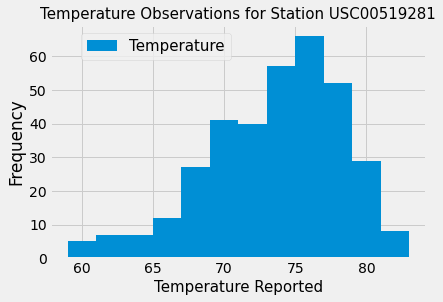

In [21]:
temp_df.plot.hist(bins=12)
plt.grid(b=True)
plt.title("Temperature Observations for Station " + station_POI[0], fontsize=15)
plt.xlabel("Temperature Reported", fontsize=15)
plt.legend(bbox_to_anchor=(0.5,1), fontsize=15)
# plt.savefig("Output/StationTemps.png")
plt.show

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-02-28', '2017-03-05')
trip_temp

[(64.0, 72.02777777777777, 78.0)]

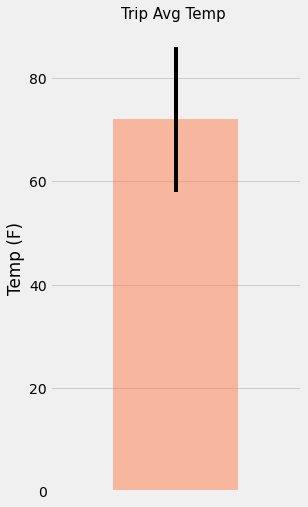

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame(trip_temp, columns = ['tmin', 'tavg', 'tmax'])
yerr = trip_temp_df['tmax']- trip_temp_df['tmin']
trip_temp_df['tavg'].plot(kind = 'bar', yerr=yerr, figsize=(4,8), alpha=0.5, color = 'coral')
plt.grid(b=True)
plt.title("Trip Avg Temp ", fontsize=15)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
rainfalls = session.query(*sel).filter(Measurement.date.between('2017-02-28', '2017-03-05')).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.station == Station.station).all()
for rainfall in rainfalls:
    print(rainfall)

('USC00519281', 4.720000000000001, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 4.45, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00516128', 4.07, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00517948', 2.98, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
('USC00519397', 2.7399999999999998, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519523', 2.32, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 1.1600000000000001, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,2,28)
end_date = dt.date(2017,3,6)
no_date = (end_date - start_date).days
no_date
# Use the start and end date to create a range of dates
date_list = [start_date + dt.timedelta(days=x) for x in range(no_date)]
day_mo = [f'{x.strftime("%m-%d")}' for x in date_list]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x)[0] for x in day_mo]
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_temp = pd.DataFrame(normals, columns =['tmin', 'tavg', 'tmax'])
daily_temp['Date'] = date_list
daily_temp.set_index('Date', inplace = True)
daily_temp

,tmin,tavg,tmax
Date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


(array([736388., 736389., 736390., 736391., 736392., 736393.]),
 <a list of 6 Text major ticklabel objects>)

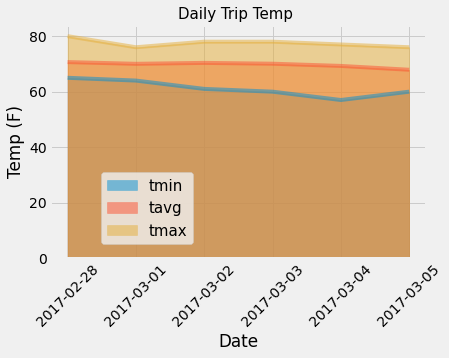

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
daily_temp.plot(kind = 'area', stacked = False)
plt.legend(bbox_to_anchor=(0.4,0.4), fontsize=15)
plt.grid(b=True)
plt.title("Daily Trip Temp ", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Temp (F)")
plt.xticks(rotation = 45)

# Bonus Analysis

In [30]:
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [31]:
# average temp in june 2016
june_df = measurement_df[(measurement_df['date'] >='2016-06-01') & (measurement_df['date'] <='2016-06-30')]
avg_june = june_df['tobs'].mean()
avg_june

# average temp in Dec 2017
dec_df = measurement_df[(measurement_df['date'] >='2016-12-01') & (measurement_df['date'] <='2016-12-31')]
avg_dec = dec_df['tobs'].mean()
avg_dec

if avg_june > avg_dec:
    print(f'avg temperature in June, {avg_june} is higher than in Dec, {avg_dec}')
else:
    print(f'avg temperature in Dec, {avg_dec} is higher than in June, {avg_june}')

avg temperature in June, 75.17525773195877 is higher than in Dec, 71.13


# Which ttest would I prefer, paired/unpaired?

For comparing the June and Dec data, I would consider unpaired ttest, as the compared group are not related/independent to each other.

In [32]:
statistic, pval = st.ttest_ind(june_df['tobs'],dec_df['tobs'])
if pval <= 0.05:
    print(f'Since pval = {pval} < 0.05 hence we reject the null hypotyesis. The two samples does not have the identical average (expected) value')
else:
    print(f'Since pval = {pval} > 0.05 hence we accept the null hypotyesis. The two samples have the identical average (expected) value')

Since pval = 1.838235725849169e-27 < 0.05 hence we reject the null hypotyesis. The two samples does not have the identical average (expected) value
